In [1]:
git_repo = '../../../../'

import sys
import os

sys.path.insert(0, os.path.join(git_repo, 'BNP_sensitivity/GMM_clustering/'))
sys.path.insert(0, '../../../../LinearResponseVariationalBayes.py/')

# Linear response libraries
import LinearResponseVariationalBayes as vb
import LinearResponseVariationalBayes.SparseObjectives as obj_lib
import LinearResponseVariationalBayes.OptimizationUtils as opt_lib

# Local libraries
import gmm_clustering_lib as gmm_utils
import modeling_lib 
import functional_sensitivity_lib as fun_sens_lib 
import utils_lib

import matplotlib.pyplot as plt
%matplotlib inline

from copy import deepcopy

from autograd import numpy as np
from autograd import scipy as sp

# import numpy as np
# import scipy as sp

np.random.seed(453453)

import json 

# Load results from previous fit.

In [2]:
json_input_file = os.path.join('./iris_fits_for_nips/bnp_full_data_fit_alpha3.5_iris.json')

with open(json_input_file, 'r') as fp:
    fit_dict = json.load(fp)
    model = gmm_utils.get_model_from_checkpoint(fit_dict)
    model_ = gmm_utils.get_model_from_checkpoint(fit_dict)
    best_param = model.global_vb_params.get_free()
    kl_hessian = gmm_utils.get_kl_hessian_from_checkpoint(fit_dict)

In [3]:
moment_model = gmm_utils.InterestingMoments(model)
dg_deta = moment_model.get_moment_jacobian(best_param)
#linear_sens = gmm_utils.LinearSensitivity(model, moment_model, kl_hessian)

In [4]:
moment_model.set_moments_from_free_par(best_param)
print(moment_model.moment_params)

Moment parameters:
	centroids:
[[ 0.37616072 -0.83707702  0.54884496 -0.7575262   0.2689322  -0.0696174
  -0.09108048 -0.0901519  -0.0830252  -0.07363194 -0.06329507 -0.04748658]
 [-0.2382035   0.36417318 -0.04613331 -0.46864103 -0.41126225 -0.25698699
  -0.25486633 -0.24619905 -0.23239487 -0.21276703 -0.18742608 -0.25461831]
 [ 0.93168929 -2.29445008  1.6196464   0.69768906  1.65617262  0.65492876
   0.57377396  0.50052968  0.42774972  0.35628876  0.28845206  0.68913405]
 [ 0.27920097 -0.95459394  0.91779967  0.4274394   0.29205     0.23685243
   0.20018611  0.16565304  0.1329439   0.1035606   0.07862009  0.25047796]]
	cluster_weights:
[0.44006818 0.32630923 0.19817012 0.00866061 0.00772923 0.00431383
 0.00328868 0.00252916 0.00195602 0.00151891 0.0011831  0.00427294]
	v_sticks:
[-0.24245967  0.33802859  1.79311681 -1.33902551 -1.07519277 -1.52972003
 -1.56822299 -1.59596054 -1.61658644 -1.63195125 -1.64325976]


In [5]:
print(model.prior_params)

prior_params:
	alpha: [3.5]
	prior_centroid_mean: [0.]
	prior_centroid_info: [0.1]
	prior_gamma_df: [8.]
	prior_gamma_inv_scale:
[[0.62 0.   0.   0.  ]
 [0.   0.62 0.   0.  ]
 [0.   0.   0.62 0.  ]
 [0.   0.   0.   0.62]]


In [6]:
alpha0 = model.prior_params['alpha'].get()[0]
print(alpha0)

3.5


# Define a perturbation in the logit v space.

In [7]:
# def log_phi(logit_v):
#     return - logit_v - np.log1p(np.exp(-logit_v))

# def phi(logit_v):
#     return np.exp(log_phi(logit_v))

# Define a perturbation in the logit v space.

phi_center = 2
#phi_log_rescale = stick_sens.get_log_p0_logit_stick(phi_center)
phi_log_rescale = -np.log(0.5)
print(phi_log_rescale)
def log_phi(logit_v):
    return(-0.5 * (logit_v - phi_center) ** 2 - phi_log_rescale)

def phi(logit_v):
    return np.exp(log_phi(logit_v))



0.6931471805599453


This perturbation class is based on the contamination model

$$
p_c(\theta | \epsilon, \phi) =  p_0(\theta) \left(1 + \epsilon \phi(\theta) \right)
$$

This corresponds to Gustafson's linear model.  One big problem is that you must take $\epsilon \rightarrow \infty$.  Another is that, even if you set it up as a normalized mixture, the scale of the perturbation determines the derivative.  I think it is worth experimenting with the model

\begin{align}
p_c(\theta | \epsilon, \phi) &= p_0(\theta)^{1 - \epsilon} p_1(\theta)^\epsilon \\
& = p_0(\theta) \left(\frac{p_1(\theta)}{p_0(\theta)}\right)^\epsilon \\
& =: p_0(\theta) (C_1 \phi(\theta)) ^ \epsilon
\end{align}

because, among other things, it is invariant to the scaling $C_1$.


In [8]:
prior_perturbation = fun_sens_lib.PriorPerturbation(model, log_phi, logit_v_ub=8, logit_v_lb = -8)
print(
    prior_perturbation.log_norm_p0,
    prior_perturbation.log_norm_pc,
    prior_perturbation.log_norm_p0_logit,
    prior_perturbation.log_norm_pc_logit)

-1.2527629265819875 -3.8626230126188354 -1.253936900542948 -3.861448867258614


phi max:  0.4997727846542519


Text(0.5,1,'Priors in logit space')

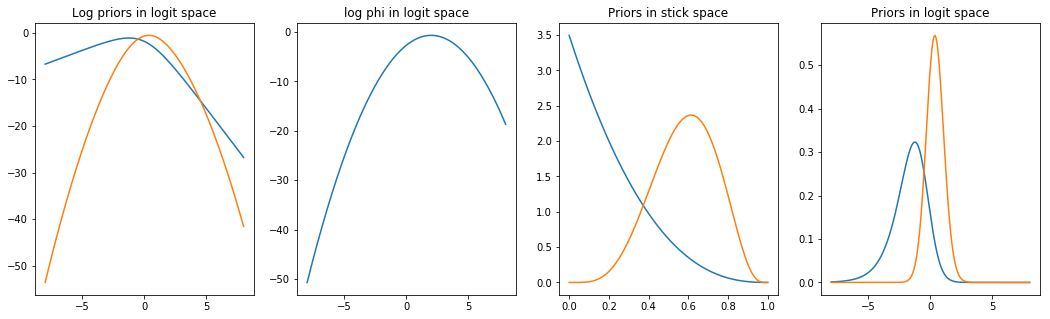

In [49]:
prior_perturbation.set_epsilon(1.0)

logit_v_grid = np.linspace(prior_perturbation.logit_v_lb, 
                               prior_perturbation.logit_v_ub, 200)

v_grid = np.exp(logit_v_grid) / (1 + np.exp(logit_v_grid))

print('phi max: ', np.max(phi(logit_v_grid)))

plt.figure(1, figsize=(18, 5))

#plt.plot(v_grid, phi(logit_v_grid))
plt.subplot(141)
plt.plot(logit_v_grid, prior_perturbation.get_log_p0_logit(logit_v_grid))
plt.plot(logit_v_grid, prior_perturbation.get_log_pc_logit(logit_v_grid))
plt.title('Log priors in logit space')

plt.subplot(142)
plt.plot(logit_v_grid, prior_perturbation.log_phi(logit_v_grid))
plt.title('log phi in logit space')

plt.subplot(143)
plt.plot(v_grid, np.exp(prior_perturbation.get_log_p0(v_grid)))
plt.plot(v_grid, np.exp(prior_perturbation.get_log_pc(v_grid)))
plt.title('Priors in stick space')

plt.subplot(144)
plt.plot(logit_v_grid, np.exp(prior_perturbation.get_log_p0_logit(logit_v_grid)))
plt.plot(logit_v_grid, np.exp(prior_perturbation.get_log_pc_logit(logit_v_grid)))
plt.title('Priors in logit space')


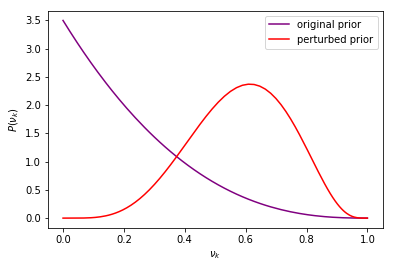

In [10]:
prior_perturbation.set_epsilon(1.0)
plt.plot(v_grid, np.exp(prior_perturbation.get_log_p0(v_grid)), color = 'purple')
plt.plot(v_grid, np.exp(prior_perturbation.get_log_pc(v_grid)), color = 'red')

plt.ylabel('$P(\\nu_k)$')
plt.xlabel('$\\nu_k$')
plt.legend(('original prior', 'perturbed prior'))

# plt.savefig('../../../writing/NIPS_2018_BNP_workshop/functional_sens_results/perturbed_prior1_init3_5.png')

In [11]:
prior_plot_array = np.array([v_grid, 
                            np.exp(prior_perturbation.get_log_p0(v_grid)), 
                            np.exp(prior_perturbation.get_log_pc(v_grid))])

In [12]:
# np.savetxt('../../../writing/NIPS_2018_BNP_workshop/data_for_figures/prior_pert2.csv', 
#           prior_plot_array, delimiter = ',')

# Choose the number of GH points.

In [13]:
import LinearResponseVariationalBayes.ExponentialFamilies as ef
model.global_vb_params.set_free(best_param)
vb_params = deepcopy(model.vb_params)

prior_perturbation.set_epsilon(1.0)

expected_perturbations_list = []
gh_deg_list = np.arange(3, 100, 1)
for gh_deg in gh_deg_list:
    gmm_utils.set_gauss_hermite_points(
        prior_perturbation.model.vb_params, gh_deg=gh_deg)
    expected_perturbations_list.append(
        prior_perturbation.get_e_log_perturbation(sum_vector=False))

print(expected_perturbations_list[0])
expected_perturbations_list = np.array(expected_perturbations_list)
#print(expected_perturbations_list.shape)
diffs = (expected_perturbations_list[1:, :] - \
         expected_perturbations_list[:-1, :]) / \
        np.abs(expected_perturbations_list[1:, :] + 1e-6)
#print(np.max(diffs, axis=1))
max_diffs = np.max(np.abs(diffs), axis=1)
print(max_diffs)
gh_deg_threshold = np.argmax(max_diffs < 1e-5)
gh_deg = max(20, gh_deg_threshold)
print(gh_deg, gh_deg_threshold, len(max_diffs))

[3.22067856 2.09798893 0.82098593 6.73768664 5.89387502 7.57322606
 7.74816029 7.87625095 7.9720775  8.04354461 8.0960999 ]
[4.23347322e-16 2.75773607e-16 4.58523454e-16 6.62527544e-16
 4.69114903e-16 3.34233445e-16 2.22822297e-16 4.41685029e-16
 4.41685029e-16 4.41685029e-16 3.34233445e-16 3.43892591e-16
 3.43892591e-16 3.43892591e-16 4.52085393e-16 4.52085393e-16
 3.01390262e-16 4.38817861e-16 5.40921169e-16 4.23347322e-16
 3.34233445e-16 3.01390262e-16 4.41685029e-16 2.20842515e-16
 4.41685029e-16 2.63644878e-16 6.62527544e-16 6.62527544e-16
 4.13660410e-16 3.38299901e-16 2.19408930e-16 3.34233445e-16
 2.70460585e-16 4.38817861e-16 3.38299901e-16 4.58523454e-16
 4.45644593e-16 2.25533268e-16 4.38817861e-16 2.11673661e-16
 2.63644878e-16 2.34557452e-16 4.69114903e-16 2.63644878e-16
 2.20842515e-16 4.51066535e-16 5.63833169e-16 2.25533268e-16
 3.01390262e-16 4.51066535e-16 2.25533268e-16 2.75773607e-16
 2.63644878e-16 4.13660410e-16 2.22822297e-16 2.70460585e-16
 4.23347322e-16 4.4564

In [14]:
# First fit with no perturbation but the increased number of gh points.

model.objective.logger.print_every = 10
gmm_utils.set_gauss_hermite_points(model.vb_params, gh_deg=gh_deg)

best_param_0, converged, x_conv, f_conv, grad_conv, obj_opt, opt_results = \
    opt_lib.repeatedly_optimize(
        objective=prior_perturbation.objective,
        optimization_fun=lambda x: gmm_utils.precondition_and_optimize(model.objective, x),
        init_x=best_param,
        initial_optimization_fun=None,
        max_iter=100,
        gtol=1e-8, ftol=1e-8, xtol=1e-8, disp=False,
        keep_intermediate_optimizations=True)

kl_hessian_0 = model.objective.fun_free_hessian(best_param_0)
    
print('Done. ')

Iter: 0	 RMSE: 11.270059446445549	 Objective: -322.0726278609656
Iter: 1	 RMSE: 11.27005950553595	 Objective: -322.07262787588195
Iter: 2	 RMSE: 11.270059590816372	 Objective: -322.0726278758854
Optimization terminated successfully.
         Current function value: -322.072628
         Iterations: 2
         Function evaluations: 3
         Gradient evaluations: 3
         Hessian evaluations: 0
Iter: 3	 RMSE: 11.270059590816373	 Objective: -322.07262787588485
Iter: 4	 RMSE: 11.270059590777818	 Objective: -322.0726278758837
         Current function value: -322.072628
         Iterations: 0
         Function evaluations: 2
         Gradient evaluations: 1
         Hessian evaluations: 0
Done. 


# Examine Fit 

In [15]:
pca_fit, pc_features, colors1, colors2 = utils_lib.get_plot_data(model.y)

In [16]:
# look at results
bnp_clusters = np.argmax(model.e_z, axis = 1)
bnp_centroids = model.vb_params['global']['centroids'].get()

bnp_cluster_infos = model.vb_params['global']['gamma'].get()
bnp_cluster_covs = np.linalg.inv(bnp_cluster_infos)

In [17]:
# we plot in PCA space
bnp_centroids_pc, bnp_cluster_covs_pc = \
    utils_lib.transform_params_to_pc_space(pca_fit, bnp_centroids, bnp_cluster_covs)

Text(0,0.5,'PC2')

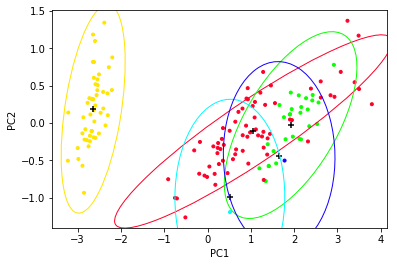

In [18]:
# plot results

fig1 = plt.figure(1)
fig = fig1.add_subplot(111)

colors1_ = deepcopy(colors1)
# colors1_[0] = colors1[2]
# colors1_[1] = colors1[0]
# colors1_[2] = colors1[1]

utils_lib.plot_clusters(pc_features[:, 0], pc_features[:, 1], bnp_clusters, \
              colors1_, fig, \
              centroids = bnp_centroids_pc[:, np.unique(bnp_clusters)], \
              cov = bnp_cluster_covs_pc[np.unique(bnp_clusters)])

fig.set_xlabel('PC1')
fig.set_ylabel('PC2')

# plt.savefig('../../../writing/functional_sensitivity_writing/parametric_sens_results/init_fit_alph8.0.png')

# Define prior perturbation

In [19]:
# This expects the hyperparameter to be at its optimal value.
prior_perturbation.set_epsilon(0.0)
epsilon_sensitivity = \
    obj_lib.ParametricSensitivity(
        objective_fun=model.set_z_get_kl,
        input_par=prior_perturbation.model.global_vb_params,
        output_par=moment_model.moment_params,
        hyper_par=prior_perturbation.epsilon_param,
        input_to_output_converter=moment_model.set_moments,
        optimal_input_par=best_param_0,
        objective_hessian=kl_hessian_0,
        hyper_par_objective_fun=prior_perturbation.get_e_log_perturbation)

In [20]:
prior_perturbation.get_e_log_perturbation()
np.linalg.norm(epsilon_sensitivity.get_dinput_dhyper())

27.698775629116504

## Fit with perturbation

In [21]:
epsilon = 1.0 # prior_perturbation.epsilon_param.get()
print('Epsilon: ', epsilon)

best_param_phi_pred = \
    epsilon_sensitivity.predict_input_par_from_hyperparameters(epsilon)
output_phi_pred = epsilon_sensitivity.predict_output_par_from_hyperparameters(
    epsilon, linear=True)

print('Predicted differences: ', np.linalg.norm(best_param_phi_pred - best_param_0))

Epsilon:  1.0
Predicted differences:  27.6987756291165


In [22]:
# Then fit with the perturbation.
prior_perturbation.set_epsilon(epsilon)
print(prior_perturbation.epsilon_param)
best_param_phi, converged, x_conv, f_conv, grad_conv, obj_opt, opt_results = \
    opt_lib.repeatedly_optimize(
        objective=prior_perturbation.objective,
        optimization_fun=
            lambda x: gmm_utils.precondition_and_optimize(
                prior_perturbation.objective, x),
        init_x=best_param_phi_pred,
        initial_optimization_fun=None,
        keep_intermediate_optimizations=True)

output_phi = moment_model.set_and_get_moments_from_free_par(best_param_phi)
output_0 = moment_model.set_and_get_moments_from_free_par(best_param_0)

print('Done. Converged: ', converged)

print('This is nonzero if phi did anything:', np.linalg.norm(best_param_phi - best_param_0))

epsilon: 1.0
Iter  0  value:  81.97788665457583
Iter  1  value:  56.43696743999726
Iter  2  value:  6.701305737458583
Iter  3  value:  -58.905524081932136
Iter  4  value:  -117.39712566902901
Iter  5  value:  -173.56801898498696
Iter  6  value:  -214.017609057545
Iter  7  value:  -225.3692317718537
Iter  8  value:  -217.5770934064981
Iter  9  value:  -231.85752027109396
Iter  10  value:  -239.62011927095176
Iter  11  value:  -239.65589874310245
Iter  12  value:  -243.89749202095408
Iter  13  value:  -249.66850622806854
Iter  14  value:  -260.3906391712767
Iter  15  value:  -270.3589033670414
Iter  16  value:  -247.27717166616264
Iter  17  value:  -275.37906647959477
Iter  18  value:  -276.74653459280444
Iter  19  value:  -277.46164050950955
Iter  20  value:  -278.1670747599395
Iter  21  value:  -278.17056089273854
Iter  22  value:  -278.3445416214544
Iter  23  value:  -278.74111159810843
Iter  24  value:  -279.0191733739583
Iter  25  value:  -279.25840498061854
Iter  26  value:  -279.5

Epsilon: 1.0


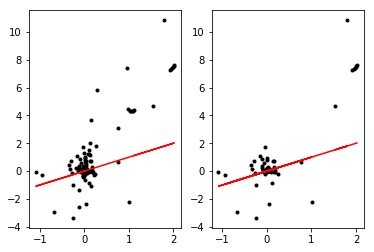

In [23]:
print('Epsilon:', epsilon)

plt.figure()
plt.subplot(1, 2, 1)
plt.plot(best_param_phi - best_param_0, best_param_phi_pred - best_param_0, 'k.')
plt.plot(best_param_phi - best_param_0, best_param_phi - best_param_0, 'r')

plt.subplot(1, 2, 2)
plt.plot(output_phi - output_0, output_phi_pred - output_0, 'k.')
plt.plot(output_phi - output_0, output_phi - output_0, 'r')

In [24]:
_ = model.set_from_global_free_par(best_param_0)
print('original expected number of clusters: ', modeling_lib.get_e_number_clusters_from_logit_sticks(model))

original expected number of clusters:  6.124604107156842


In [25]:
_ = model.set_from_global_free_par(best_param_phi)
print('perturbed expected number of clusters: ', modeling_lib.get_e_number_clusters_from_logit_sticks(model))

perturbed expected number of clusters:  5.29155185820829


In [26]:
_ = model.set_from_global_free_par(best_param_phi_pred)
print('predicted expected number of clusters: ', modeling_lib.get_e_number_clusters_from_logit_sticks(model))

predicted expected number of clusters:  3.9114504519172724


# Predict for a range of perturbations

In [50]:
# epsilon_vec = np.arange(, 15)
epsilon_vec = np.linspace(0, 1, 11)
print(epsilon_vec)

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


In [51]:
best_param_phi_array = []
best_param_phi_pred_array = []

output_phi_array = []
output_phi_pred_array = []

In [29]:
# best_param_phi_array = np.load('./best_param_phi_array.npy')

In [52]:
for i in range(len(epsilon_vec)): 
    epsilon = epsilon_vec[i]
    print('\n\nEpsilon: ', epsilon)
    
    # get linear predictions
    best_param_phi_pred = \
        epsilon_sensitivity.predict_input_par_from_hyperparameters(epsilon)
    output_phi_pred = epsilon_sensitivity.predict_output_par_from_hyperparameters(
        epsilon, linear=True)

    print('Predicted differences: ', np.linalg.norm(best_param_phi_pred - best_param_0))
    
    # Then fit with the perturbation.
    prior_perturbation.set_epsilon(epsilon_vec[i])
    print(prior_perturbation.epsilon_param)
    best_param_phi, converged, x_conv, f_conv, grad_conv, obj_opt, opt_results = \
        opt_lib.repeatedly_optimize(
            objective=prior_perturbation.objective,
            optimization_fun=
                lambda x: gmm_utils.precondition_and_optimize(
                    prior_perturbation.objective, x),
            init_x=best_param_phi_pred,
            initial_optimization_fun=None,
            keep_intermediate_optimizations=True)

    output_phi = moment_model.set_and_get_moments_from_free_par(best_param_phi)

    print('Done. Converged: ', converged)

    print('Predicted differences: ', np.linalg.norm(best_param_phi_pred - best_param_0))
    print('Actual differences: (This is nonzero if phi did anything):',
          np.linalg.norm(best_param_phi - best_param_0))
    
    # save results: 
    best_param_phi_array.append(best_param_phi)
    best_param_phi_pred_array.append(best_param_phi_pred)
    
    output_phi_array.append(output_phi)
    output_phi_pred_array.append(output_phi_pred)
    

Epsilon:  0.0
Predicted differences:  0.0
epsilon: 0.0
Iter  360  value:  -322.07262787588564
Iter  361  value:  -322.0726278758854
         Current function value: -322.072628
         Iterations: 0
         Function evaluations: 2
         Gradient evaluations: 1
         Hessian evaluations: 0
Done. Converged:  True
This is nonzero if phi did anything: 5.9650227134669265e-15
Epsilon:  0.1
Predicted differences:  2.7698775629116508
epsilon: 0.1
Iter  362  value:  -315.19208053301014
Iter  363  value:  -316.0971322010311
Iter  364  value:  -316.2663539452466
Iter  365  value:  -316.2910242959766
Iter  366  value:  -316.29204289593844
Iter  367  value:  -316.2920535916784
Iter  368  value:  -316.29205362440405
Iter  369  value:  -316.2920536244061
Optimization terminated successfully.
         Current function value: -316.292054
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8
         Hessian evaluations: 0
Iter  370  value:  -316.29205362440564

Iter  470  value:  -278.63631118150636
Iter  471  value:  -288.4760452885295
Iter  472  value:  -289.5045412736572
Iter  473  value:  -290.6005306988224
Iter  474  value:  -291.8960014595552
Iter  475  value:  -286.62464177358754
Iter  476  value:  -292.4277932517182
Iter  477  value:  -292.6609994188771
Iter  478  value:  -292.9843313132494
Iter  479  value:  -293.0099944006259
Iter  480  value:  -293.1038546418909
Iter  481  value:  -293.6376469394524
Iter  482  value:  -293.0581123874468
Iter  483  value:  -294.0190623884198
Iter  484  value:  -293.6053573108889
Iter  485  value:  -294.17073184113536
Iter  486  value:  -294.1915495913706
Iter  487  value:  -294.2518426674176
Iter  488  value:  -294.36139756160475
Iter  489  value:  -294.51307154355555
Iter  490  value:  -294.53462001081897
Iter  491  value:  -294.5394301819432
Iter  492  value:  -294.48594334700437
Iter  493  value:  -294.53440092759047
Iter  494  value:  -294.5406442923262
Iter  495  value:  -294.54140604230616
Ite

Iter  633  value:  -281.68629362458375
Iter  634  value:  -281.722415283202
Iter  635  value:  -283.21289889860543
Iter  636  value:  -283.52584811152775
Iter  637  value:  -284.4964409377277
Iter  638  value:  -278.91079564311786
Iter  639  value:  -285.05894842353587
Iter  640  value:  -285.35519582625267
Iter  641  value:  -285.543480032896
Iter  642  value:  -285.7192132073373
Iter  643  value:  -285.83902037765233
Iter  644  value:  -286.1452443848461
Iter  645  value:  -286.289832123421
Iter  646  value:  -285.99704856708996
Iter  647  value:  -286.60214401662927
Iter  648  value:  -286.72827474434433
Iter  649  value:  -286.86223838403794
Iter  650  value:  -286.9108975522832
Iter  651  value:  -286.92273948698175
Iter  652  value:  -286.9278887083928
         Current function value: -286.927889
         Iterations: 50
         Function evaluations: 51
         Gradient evaluations: 42
         Hessian evaluations: 0
Iter  653  value:  -286.92788870839377
Iter  654  value:  -286

In [31]:
# np.save('best_param_phi_array', best_param_phi_array)

In [32]:
output_0 = moment_model.set_and_get_moments_from_free_par(best_param_0)

In [53]:
# for i in range(len(epsilon_vec)): 
#     plt.figure(figsize=(8, 4))
#     plt.subplot(1, 2, 1)
#     plt.plot(best_param_phi_array[i] - best_param_0, 
#              best_param_phi_pred_array[i] - best_param_0, 'k.')
#     plt.plot(best_param_phi_array[i] - best_param_0, 
#              best_param_phi_array[i] - best_param_0, 'r')
#     plt.xlabel('true diff global free params')
#     plt.ylabel('pred diff global free params')
#     plt.title('epsilon = {}'.format(epsilon_vec[i]))

#     plt.subplot(1, 2, 2)
#     plt.plot(output_phi_array[i] - output_0, 
#              output_phi_pred_array[i] - output_0, 'k.')
#     plt.plot(output_phi_array[i] - output_0, 
#              output_phi_array[i] - output_0, 'r')
#     plt.xlabel('true diff moment params')
#     plt.ylabel('pred diff moment params')
#     plt.title('epsilon = {}'.format(epsilon_vec[i]))
    
#     plt.tight_layout()

    

# Lets also look at the expected number of clusters

In [57]:
# This expects the hyperparameter to be at its optimal value.
#e_num_clusters_class = gmm_utils.ExpectedNumClustersFromZ(model)
#e_num_clusters_class = gmm_utils.ExpectedNumClustersFromLogitSticks(model)
e_num_clusters_class.set_e_num_clusters_from_free_param(best_param_0)

prior_perturbation.set_epsilon(0.0)
cluster_sensitivity = \
    obj_lib.ParametricSensitivity(
        objective_fun=model.set_z_get_kl,
        input_par=e_num_clusters_class.model.global_vb_params,
        output_par=e_num_clusters_class.e_num_clusters,
        hyper_par=prior_perturbation.epsilon_param,
        input_to_output_converter=e_num_clusters_class.set_e_num_clusters,
        optimal_input_par=best_param_0,
        objective_hessian=kl_hessian_0,
        hyper_par_objective_fun=prior_perturbation.get_e_log_perturbation)

In [58]:
e_num_clusters_pred = []
e_num_clusters_true = []
for i in range(len(epsilon_vec)):
    param_pred = cluster_sensitivity.predict_input_par_from_hyperparameters(
        epsilon_vec[i])
    e_num_clusters_true.append()
#     e_num_clusters_true.append(
#             e_num_clusters_class.set_and_get_e_num_clusters_from_free_param(
#                 best_param_phi_array[i]))
    
#     e_num_clusters_pred.append(
#         cluster_sensitivity.predict_output_par_from_hyperparameters(
#             epsilon_vec[i], linear = False))

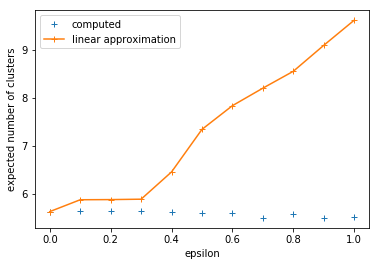

In [59]:
plt.plot(epsilon_vec, e_num_clusters_true, '+')
plt.plot(epsilon_vec, e_num_clusters_pred, '+-')

plt.xlabel('epsilon')
plt.ylabel('expected number of clusters')

plt.legend(('computed', 'linear approximation'))

# plt.savefig('../../../writing/NIPS_2018_BNP_workshop/functional_sens_results/pred_num_clusters1_init3_5.png')

In [40]:
np.array(e_num_clusters_true)

array([[5.65082502],
       [5.65707672],
       [5.64932715],
       [5.63336636],
       [5.61547942],
       [5.59994758],
       [5.50640231],
       [5.58263611],
       [5.51066366],
       [5.51593093]])

In [43]:
func_sens_results_array = np.array([epsilon_vec, 
                                   np.array(e_num_clusters_true).squeeze(), 
                                   np.array(e_num_clusters_pred).squeeze()])

np.savetxt('../../../writing/NIPS_2018_BNP_workshop/data_for_figures/prior_pert2_enum_clust_results.csv', 
        func_sens_results_array, 
          delimiter = ',')

In [44]:
def plot_results_from_free_params(model, global_free_params, fig): 
    # look at results
    model.global_vb_params.set_free(global_free_params)
    model.set_optimal_z()

    bnp_clusters = np.argmax(model.e_z, axis = 1)
    bnp_centroids = model.vb_params['global']['centroids'].get()

    bnp_cluster_infos = model.vb_params['global']['gamma'].get()
    bnp_cluster_covs = np.linalg.inv(bnp_cluster_infos)
    
    pca_fit, pc_features, colors1, colors2 = utils_lib.get_plot_data(model.y)
    
    # we plot in PCA space
    bnp_centroids_pc, bnp_cluster_covs_pc = \
        utils_lib.transform_params_to_pc_space(pca_fit, bnp_centroids, bnp_cluster_covs)
        
    utils_lib.plot_clusters(pc_features[:, 0], pc_features[:, 1], bnp_clusters, \
              colors1_, fig, \
              centroids = bnp_centroids_pc[:, np.unique(bnp_clusters)], \
              cov = bnp_cluster_covs_pc[np.unique(bnp_clusters)])

    fig.set_xlabel('PC1')
    fig.set_ylabel('PC2')


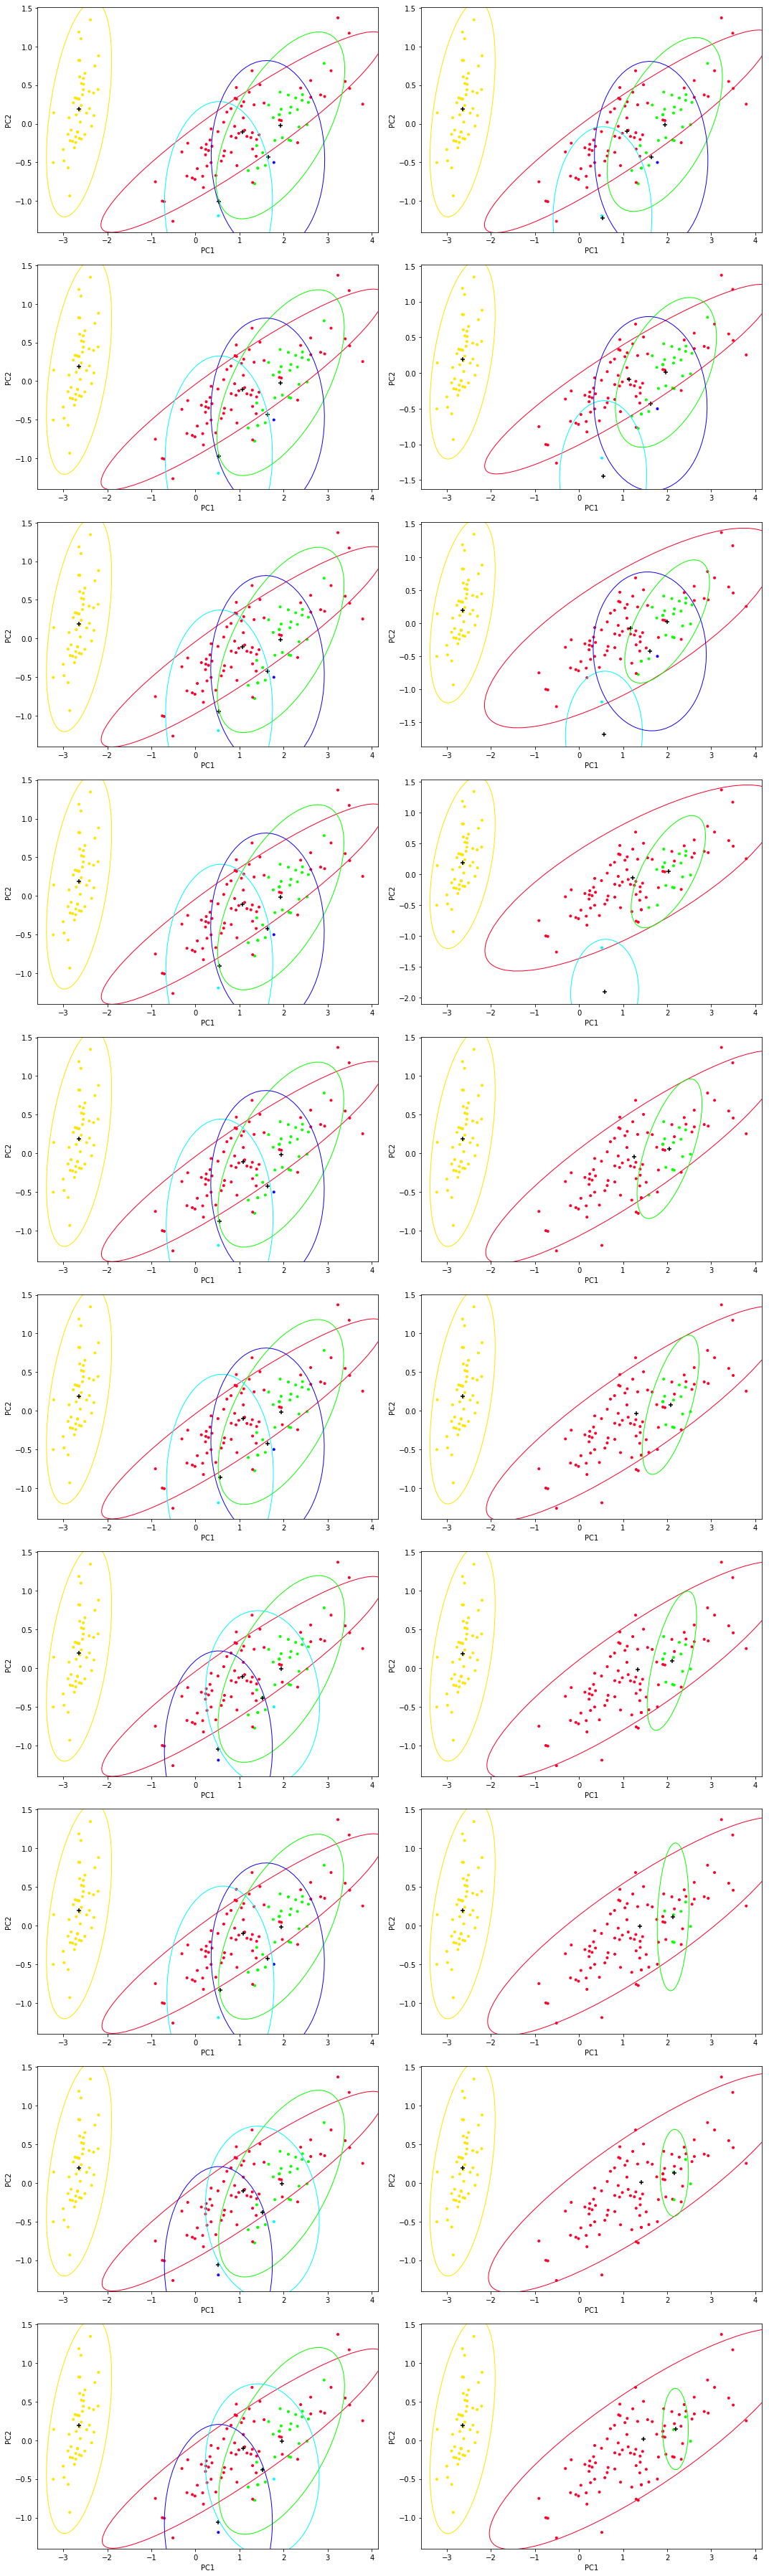

In [45]:
f, axarr = plt.subplots(len(epsilon_vec), 2, figsize = (15, 50))

for i in range(len(epsilon_vec)): 
    plot_results_from_free_params(model, best_param_phi_array[i], axarr[i, 0])
    plot_results_from_free_params(model, best_param_phi_pred_array[i], axarr[i, 1])

f.tight_layout()